# Getting started

Once you've chosen your scenario from the README, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

## Scenario and Problem Statement

In [1]:
import pandas as pd
% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [2]:
## Load the data into a DataFrame- This is the file with 2M rows reduced from 10M rows original.
df = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [3]:
print df.shape # There are 270,955 rows and 18 columns
print df.columns
print df.dtypes

(270955, 18)
Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Item Number', u'Item Description', u'Bottle Volume (ml)',
       u'State Bottle Cost', u'State Bottle Retail', u'Bottles Sold',
       u'Sale (Dollars)', u'Volume Sold (Liters)', u'Volume Sold (Gallons)'],
      dtype='object')
Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object


In [4]:
# Remove $ from certain columns
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]
for col in cols:
    df[col] = df[col].apply(lambda x: float(x[1:]))

In [5]:
# Convert dates
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

# Drop bad values
df = df.dropna()

# Convert float to integers
df["County Number"] = df["County Number"].astype(int)
df["Category"] = df["Category"].astype(int)

In [6]:
dates = df.groupby(by=["Store Number"], as_index=False) # grouping by store number 
dates = dates.agg({"Date": [np.min, np.max]}) #finding the start and end date for each store
dates.columns = [' '.join(col).strip() for col in dates.columns.values]
dates.head()

# Filter out stores that opened or closed throughout the year

lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
df = df[df["Store Number"].isin(good_stores)]
df.shape

(256181, 18)

In [7]:
#dates.columns.values

In [8]:
# Margin
df["Margin"] = (df["State Bottle Retail"] - df["State Bottle Cost"]) * df["Bottles Sold"]
df["Price per Liter"] = df["Sale (Dollars)"] / df["Volume Sold (Liters)"]
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Margin,Price per Liter
0,2015-11-04,3717,SUMNER,50674,9,Bremer,1051100,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38,27.00,9.000000
1,2016-03-02,2614,DAVENPORT,52807,82,Scott,1011100,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40,13.76,27.506667
2,2016-02-11,2106,CEDAR FALLS,50613,7,Black Hawk,1011200,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34,151.20,18.890000
3,2016-02-03,2501,AMES,50010,85,Story,1071100,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77,28.50,8.142857
4,2015-08-18,3654,BELMOND,50421,99,Wright,1031080,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55,43.20,6.171429


In [9]:
# 2015 sales data

# Stores open between 2015/01/01 - 2015/12/31- 
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales = df[mask]

#Stats for 2015
columns = ["Bottles Sold", "Sale (Dollars)"]
print("For the Year 2015:")
for item in columns:
    print(item, sales[item].sum())

# Group by store number
sales = sales.groupby(by=["Store Number"], as_index=False)

# Compute sums, means
sales = sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]

# Rename columns
sales.columns = [u'Store Number', u'City', u'2015 Sales',
       u'2015 Sales mean', u'County Number',
       u'Price per Liter mean', u'Zip Code',
       u'2015 Volume Sold (Liters)', u'2015 Volume Sold (Liters) mean',
       u'2015 Margin mean']

# Quick check
sales.head()


For the Year 2015:
('Bottles Sold', 2075799)
('Sale (Dollars)', 27375883.74000049)


,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean
0,2106,CEDAR FALLS,146038.70,277.640114,7,17.844997,50613,9719.85,18.478802,92.665779
1,2113,GOWRIE,9310.22,63.334830,94,18.507700,50543,659.85,4.488776,21.149932
2,2130,WATERLOO,111583.91,285.380844,7,16.817589,50703,6879.37,17.594297,95.215652
3,2152,ROCKWELL,7721.08,54.759433,17,13.020765,50469,633.37,4.491986,18.351277
4,2178,WAUKON,24324.18,102.633671,3,16.053844,52172,1917.12,8.089114,34.454430


(0, 10000)

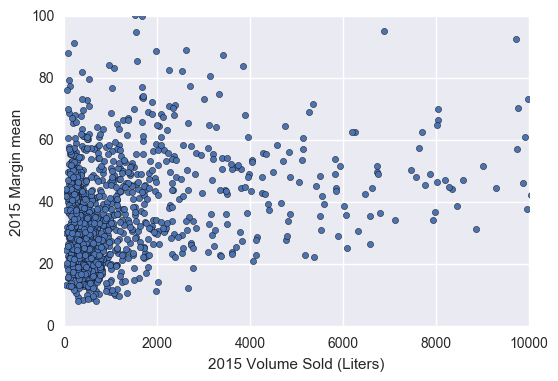

In [10]:
# Quick plot to check the computations
sales.plot(kind='scatter', y="2015 Margin mean", x="2015 Volume Sold (Liters)")
plt.ylim(0, 100)
plt.xlim(0, 10000)

In [12]:
# Q1 sales, may want to also use aggregate as above to have more columns (means, etc.)

# Sales 2015  Q1
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2015 Sales Q1"] = df2["Sale (Dollars)"]

# Sales 2016 Q1
start_date = pd.Timestamp("20160101")
end_date = pd.Timestamp("20160331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2016 Sales Q1"] = df2["Sale (Dollars)"]

# add the dates computed above to this data.
sales["First Date"] = dates["Date amin"]
sales["Last Date"] = dates["Date amax"]
sales.to_csv("sales_10pct.csv")
sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1,First Date,Last Date
0,2106,CEDAR FALLS,146038.70,277.640114,7,17.844997,50613,9719.85,18.478802,92.665779,39287.29,30478.75,2015-01-08,2016-03-31
1,2113,GOWRIE,9310.22,63.334830,94,18.507700,50543,659.85,4.488776,21.149932,2833.25,2065.90,2015-01-07,2016-03-23
2,2130,WATERLOO,111583.91,285.380844,7,16.817589,50703,6879.37,17.594297,95.215652,24272.57,27856.11,2015-01-08,2016-03-31
3,2152,ROCKWELL,7721.08,54.759433,17,13.020765,50469,633.37,4.491986,18.351277,2003.46,904.66,2015-01-08,2016-02-25
4,2178,WAUKON,24324.18,102.633671,3,16.053844,52172,1917.12,8.089114,34.454430,5856.41,5588.50,2015-01-07,2016-03-30


## Explore the data

Perform EDA and Viz, such as histograms of transaction totals, bottles sold, etc.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df[['Bottle Volume (ml)','State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)','Volume Sold (Gallons)']].describe()

,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
count,256181.000000,256181.000000,256181.000000,256181.000000,256181.000000,256181.000000,256181.000000
mean,928.522822,9.798600,14.713912,9.888169,129.890497,9.065026,2.394930
std,490.985091,7.068965,10.602874,24.338346,388.268589,29.170467,7.706013
min,50.000000,0.890000,1.340000,1.000000,1.340000,0.100000,0.030000
25%,750.000000,5.520000,8.310000,2.000000,30.390000,1.500000,0.400000
50%,750.000000,8.180000,12.300000,6.000000,70.560000,5.250000,1.390000
75%,1000.000000,11.960000,17.940000,12.000000,135.660000,10.500000,2.770000
max,6000.000000,425.000000,637.500000,2508.000000,36392.400000,2508.000000,662.540000


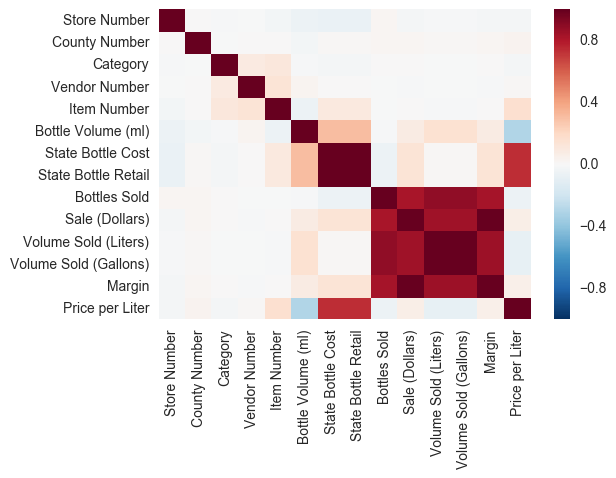

In [15]:
sns.heatmap(df.corr())

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

1. From the correlation map there is a strong relation between state bottle cost - state bottle retail, volume sold (liters)- volume sold (gallons).
2. There is colinearity between the above variables and can be removed from the table before modelling.
3. Out of the 2,709,552 rows only 2,181,902 rows qualify for the 2015 fiscal year.There are 527,650 rows that come under 2016.
4. For the year 2015 the total sales was 218,912,802 dollars from the sale of 21,552,771 bottles.
5. A bottle was sold for an average price of $13.17.
6. There are 1375 stores in the dataset(2015 and 2016).
7. There are 1194 stores that started before 03/31/15 and ended in 2016-meaning these stores
were open for the entire 2015. There are 181 stores that were opened mid 2015 or were closed
mid 2015.
8. 2015 Q1 sales has a strong correlation with 2015 sales.

## Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

## Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [16]:
sales.columns

Index([                  u'Store Number',                           u'City',
                           u'2015 Sales',                u'2015 Sales mean',
                        u'County Number',           u'Price per Liter mean',
                             u'Zip Code',      u'2015 Volume Sold (Liters)',
       u'2015 Volume Sold (Liters) mean',               u'2015 Margin mean',
                        u'2015 Sales Q1',                  u'2016 Sales Q1',
                           u'First Date',                      u'Last Date'],
      dtype='object')

(0, 4000000.0)

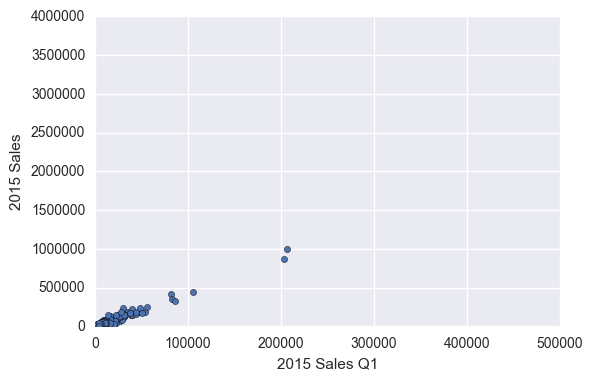

In [17]:
sales.plot.scatter(x='2015 Sales Q1', y='2015 Sales')
plt.xlim(0, 500000) #X values are truncated from 2.5M to 500,000 
plt.ylim(0, 0.4e+07) # y values are truncated from 12 million to 4 million

(0, 100000)

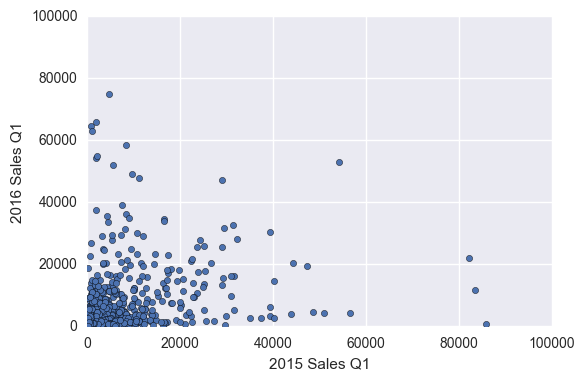

In [18]:
sales.plot.scatter(x='2015 Sales Q1', y='2016 Sales Q1')
plt.xlim(0, 100000) #X values are truncated from 2.5M to 500,000 
plt.ylim(0, 100000) # y values are truncated from 12 million to 4 million


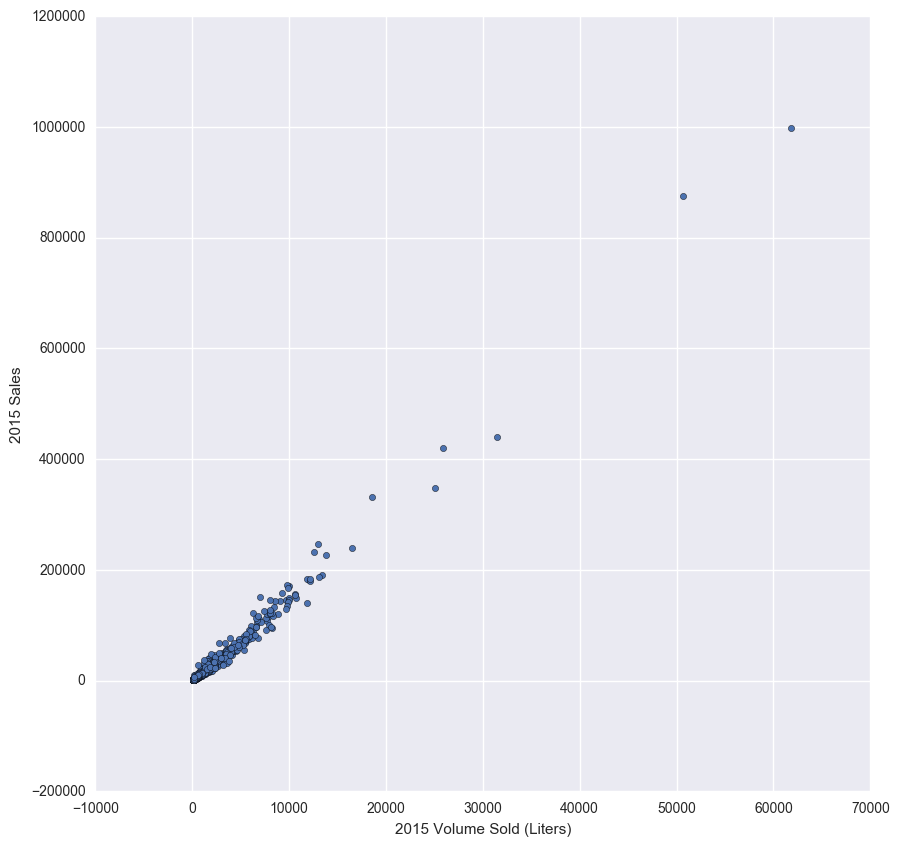

In [110]:
sales.plot.scatter(x='2015 Volume Sold (Liters)', y='2015 Sales')

In [19]:
#AT - what does this chart show us?

(0, 200000)

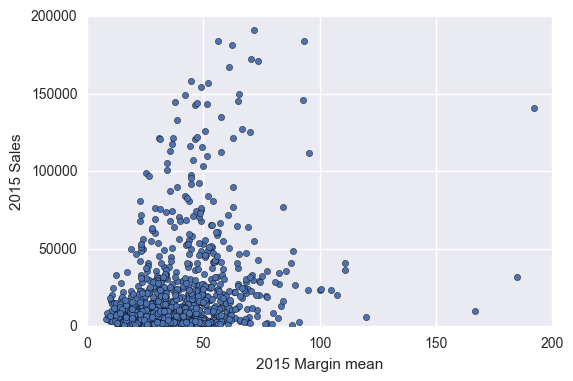

In [20]:
sales.plot.scatter(x='2015 Margin mean', y='2015 Sales')
plt.xlim(0, 200) 
plt.ylim(0, 200000)

(0, 200000)

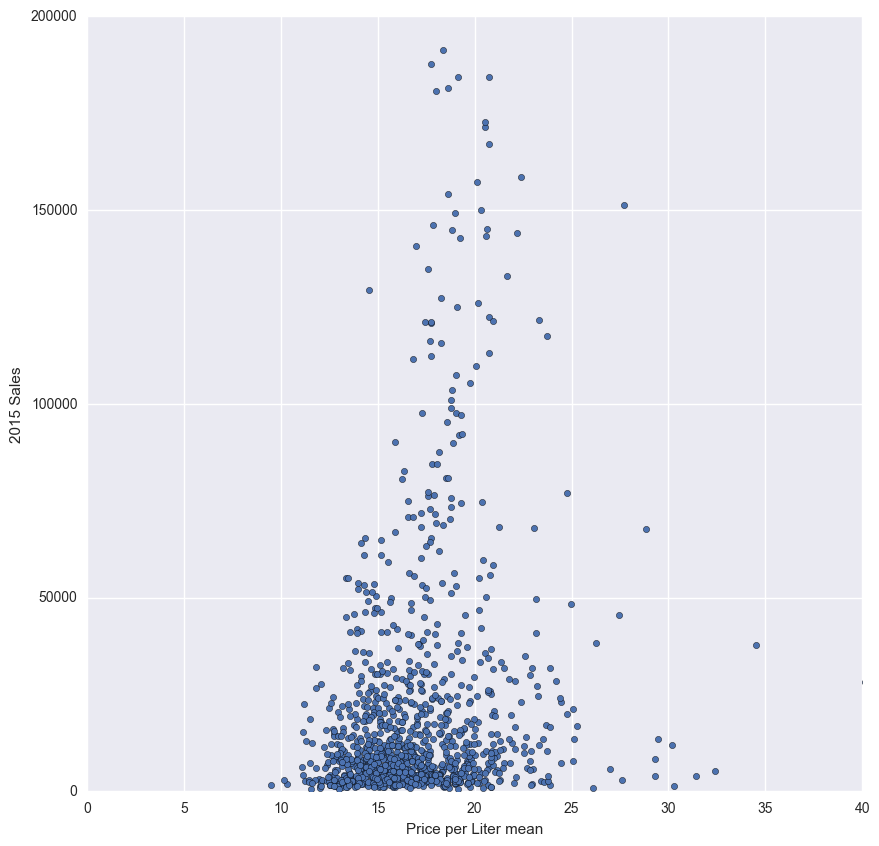

In [112]:
sales.plot.scatter(x='Price per Liter mean', y='2015 Sales')
plt.xlim(0, 40) 
plt.ylim(0, 200000)

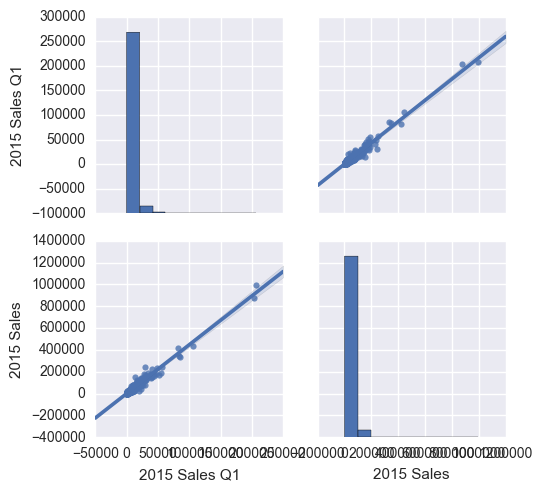

In [113]:
sns.pairplot(sales,vars=["2015 Sales Q1","2015 Sales"],kind="reg")

## Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [21]:
sales_reduced_columns = [u'2015 Sales mean', u'Price per Liter mean', u'2015 Volume Sold (Liters)',
                         u'2015 Volume Sold (Liters) mean', u'2015 Margin mean']
for x in sales_reduced_columns:
    model = sm.OLS(sales["2015 Sales"], sales[x]).fit()
    print x, ":", model.mse_model

2015 Sales mean : 1.2675696533e+12
Price per Liter mean : 724432303941.0
2015 Volume Sold (Liters) : 4.03779185059e+12
2015 Volume Sold (Liters) mean : 1.23232849207e+12
2015 Margin mean : 1.26626774762e+12


In [22]:
# The model is built using 4 variables
X = sales[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
X = sm.add_constant(X)
y = sales["2015 Sales"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             2015 Sales   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.303e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:41:14   Log-Likelihood:                -11553.
No. Observations:                1161   AIC:                         2.312e+04
Df Residuals:                    1156   BIC:                         2.314e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2329.4498    216.845    -10.742      0.000   -2754.904   -1903.996
2015 Sales Q1                 1.4306      0.056     25.608      0.000       1.321       1.540
2015 Volume Sold (Liters)    10.7129      0.196     54.600      0.000      10.328      11.098
2015 Margin mean          -6694.2396    555.937    -12.041      0.000   -7784.998   -5603.481
2015 Sales mean            2247.4137    185.970     12.085      0.000    1882.537    2612.291
==============================================================================
Omnibus:                      538.476   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39226.207
Skew:                          -1.263   Prob(JB):                         0.00
Kurtosis:                      31.364   Cond. No.                     5.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

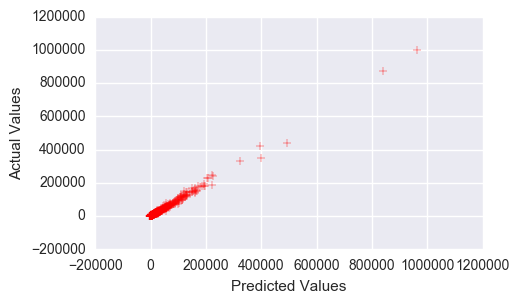

MSE: 854826464072.0


In [23]:
plt.rcParams['figure.figsize'] = 5, 3
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", model.mse_model

In [24]:
# The model is built using 3 variables- mean margin has been removed
X = sales[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Sales mean']]
X = sm.add_constant(X)
y = sales["2015 Sales"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             2015 Sales   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.912e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:41:27   Log-Likelihood:                -11622.
No. Observations:                1161   AIC:                         2.325e+04
Df Residuals:                    1157   BIC:                         2.327e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2385.1013    229.891    -10.375      0.000   -2836.151   -1934.051
2015 Sales Q1                 1.4761      0.059     24.974      0.000       1.360       1.592
2015 Volume Sold (Liters)    10.5752      0.208     50.915      0.000      10.168      10.983
2015 Sales mean               8.1404      1.471      5.534      0.000       5.254      11.027
==============================================================================
Omnibus:                      469.903   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33185.559
Skew:                          -0.988   Prob(JB):                         0.00
Kurtosis:                      29.117   Cond. No.                     1.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

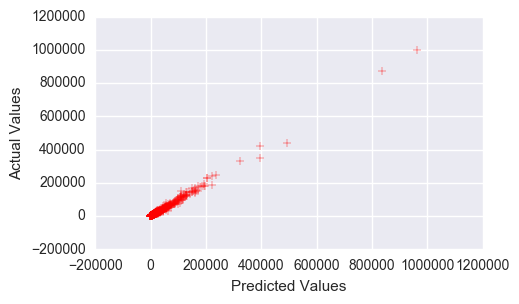

MSE: 1.13851779361e+12
This model using 3 variables has an MSE (1.13e+12) larger than the the model(8.54e+11) using 4 variabes


In [25]:
plt.rcParams['figure.figsize'] = 5, 3
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", model.mse_model
print("This model using 3 variables has an MSE (1.13e+12) larger than the the model(8.54e+11) using 4 variabes")

In [26]:
# Model using 3 variables- 2015 mean sales removed
X = sales[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean']]
X = sm.add_constant(X)
y = sales["2015 Sales"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             2015 Sales   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.909e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:41:39   Log-Likelihood:                -11622.
No. Observations:                1161   AIC:                         2.325e+04
Df Residuals:                    1157   BIC:                         2.327e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2372.8540    230.004    -10.317      0.000   -2824.126   -1921.582
2015 Sales Q1                 1.4760      0.059     24.962      0.000       1.360       1.592
2015 Volume Sold (Liters)    10.5774      0.208     50.902      0.000      10.170      10.985
2015 Margin mean             23.9616      4.399      5.447      0.000      15.330      32.593
==============================================================================
Omnibus:                      466.979   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33099.023
Skew:                          -0.975   Prob(JB):                         0.00
Kurtosis:                      29.085   Cond. No.                     1.97e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

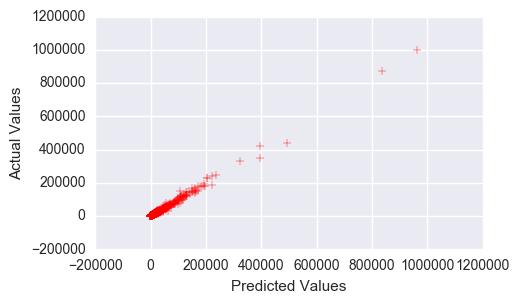

MSE: 1.13850875298e+12
This model using 3 variables has an MSE (1.13e+12) larger than the the model(8.54e+11) using 4 variabes


In [27]:
plt.rcParams['figure.figsize'] = 5, 3
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", model.mse_model
print("This model using 3 variables has an MSE (1.13e+12) larger than the the model(8.54e+11) using 4 variabes")

In [28]:
# Model using only 2 variables- mean margin and mean 2015 sales are removed
X = sales[['2015 Sales Q1','2015 Volume Sold (Liters)']]
X = sm.add_constant(X)
y = sales["2015 Sales"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             2015 Sales   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 5.721e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:41:44   Log-Likelihood:                -11637.
No. Observations:                1161   AIC:                         2.328e+04
Df Residuals:                    1158   BIC:                         2.330e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1574.8754    179.491     -8.774      0.000   -1927.040   -1222.711
2015 Sales Q1                 1.4589      0.060     24.407      0.000       1.342       1.576
2015 Volume Sold (Liters)    10.7503      0.208     51.712      0.000      10.342      11.158
==============================================================================
Omnibus:                      340.192   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37279.140
Skew:                           0.027   Prob(JB):                         0.00
Kurtosis:                      30.760   Cond. No.                     1.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

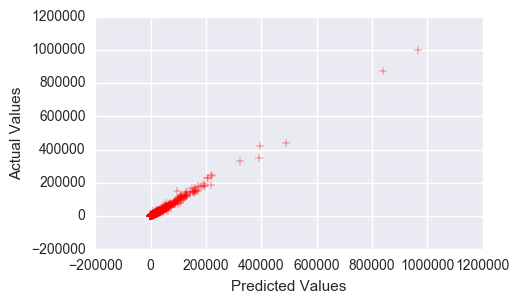

MSE: 1.70733109793e+12
Model built using only 2 variables has higher MSE than 4 variables model


In [29]:
plt.rcParams['figure.figsize'] = 5, 3
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", model.mse_model
print("Model built using only 2 variables has higher MSE than 4 variables model")

In [30]:
print sales.shape
sales_no_NA = sales.dropna(how='any') # There are NA values in 2015 Q1 sales and 2016 Q1 sales
sales_no_NA.shape

(1161, 14)


(1143, 14)

In [31]:
X = sales_no_NA[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
X = sm.add_constant(X)
y = sales_no_NA["2015 Sales"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print("The regression equation is 2015 Sales = 1.4525(2015 Q1 sales) + 10.6(2015 volume sold (liters) - 6556(2015 Margin mean) - 2200(2015 Sales Mean) - 2293)")
model.summary()


The regression equation is 2015 Sales = 1.4525(2015 Q1 sales) + 10.6(2015 volume sold (liters) - 6556(2015 Margin mean) - 2200(2015 Sales Mean) - 2293)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             2015 Sales   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.253e+04
Date:                Wed, 16 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:42:01   Log-Likelihood:                -11378.
No. Observations:                1143   AIC:                         2.277e+04
Df Residuals:                    1138   BIC:                         2.279e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2293.2530    223.770    -10.248      0.000   -2732.301   -1854.205
2015 Sales Q1                 1.4525      0.057     25.598      0.000       1.341       1.564
2015 Volume Sold (Liters)    10.6357      0.200     53.114      0.000      10.243      11.029
2015 Margin mean          -6556.2563    569.461    -11.513      0.000   -7673.569   -5438.944
2015 Sales mean            2200.8557    190.608     11.546      0.000    1826.873    2574.838
==============================================================================
Omnibus:                      512.249   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37829.348
Skew:                          -1.182   Prob(JB):                         0.00
Kurtosis:                      31.084   Cond. No.                     5.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

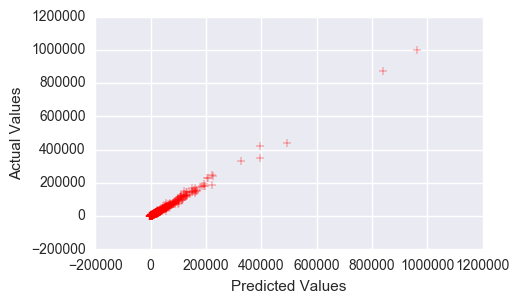

MSE: 847174475314.0
Model using 4 variables gives the lowest MSE value


In [32]:
plt.rcParams['figure.figsize'] = 5, 3
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", model.mse_model
print("Model using 4 variables gives the lowest MSE value")

In [33]:
X = sales_no_NA["2015 Sales Q1"]
y = sales_no_NA["2016 Sales Q1"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          2016 Sales Q1   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     98.83
Date:                Wed, 16 Nov 2016   Prob (F-statistic):           2.16e-22
Time:                        15:42:12   Log-Likelihood:                -12428.
No. Observations:                1143   AIC:                         2.486e+04
Df Residuals:                    1142   BIC:                         2.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
2015 Sales Q1     0.2862      0.029      9.942      0.000       0.230       0.343
==============================================================================
Omnibus:                     1857.986   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1156242.215
Skew:                          10.091   Prob(JB):                         0.00
Kurtosis:                     157.501   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

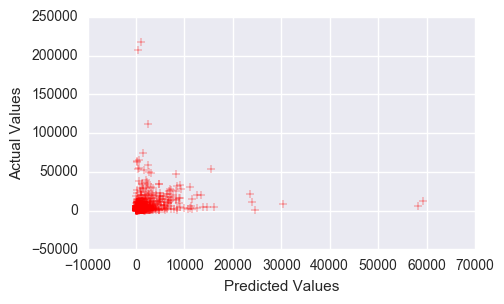

MSE: 16103841241.0


In [35]:
plt.rcParams['figure.figsize'] = 5, 3
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", model.mse_model

In [37]:
X = sales_no_NA[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
X = sm.add_constant(X)
y = sales_no_NA["2016 Sales Q1"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          2016 Sales Q1   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     9.795
Date:                Wed, 16 Nov 2016   Prob (F-statistic):           8.61e-08
Time:                        15:44:04   Log-Likelihood:                -12363.
No. Observations:                1143   AIC:                         2.474e+04
Df Residuals:                    1138   BIC:                         2.476e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      4824.5986    529.637      9.109      0.000    3785.423    5863.774
2015 Sales Q1                -0.2157      0.134     -1.606      0.109      -0.479       0.048
2015 Volume Sold (Liters)     1.4292      0.474      3.016      0.003       0.499       2.359
2015 Margin mean           -389.8568   1347.849     -0.289      0.772   -3034.404    2254.691
2015 Sales mean             123.0158    451.147      0.273      0.785    -762.157    1008.189
==============================================================================
Omnibus:                     1904.434   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1259159.365
Skew:                          10.616   Prob(JB):                         0.00
Kurtosis:                     164.209   Cond. No.                     5.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
#AT

# X = sales_no_NA[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
# X = sm.add_constant(X)
# y = sales_no_NA["2016 Sales Q1"]

# model = sm.OLS(y, X).fit()
# predictions = model.predict(X)

# model.summary()

# Your logic here is a little twisted.

# it should be

# X = sales_no_NA[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
# X = sm.add_constant(X)
# y = sales_no_NA["2015 Sales Q1"] <<<<<<-------- made change here

# model = sm.OLS(y, X).fit()
# predictions = model.predict(sales_no_NA["2016 Sales Q1"]) <<<<<<-------- made change here

# model.summary()

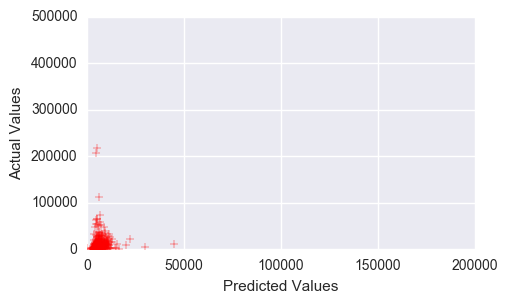

MSE: 1428944215.23


In [38]:
plt.rcParams['figure.figsize'] = 5, 3
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim(0, 200000) 
plt.ylim(0, 500000)
plt.show()
print "MSE:", model.mse_model

In [39]:
# Linear regression with regularization- Ridge CV

X_sample = sales_no_NA[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
y_sample = sales_no_NA[["2015 Sales"]]
lm = linear_model.RidgeCV(alphas=[0.1, 1, 10])
model = lm.fit(X_sample,y_sample)
predictions = model.predict(X_sample)
print "With Ridge CV:", model.score(X_sample,y_sample)
print "alpha",model.alpha_
print model.coef_
print('"With ridgeCV regularizarization R2 value decreased from 0.991 for a OLS model to 0.991"')


With Ridge CV: 0.991330768809
alpha 1.0
[[  1.45304108e+00   1.06342101e+01  -6.46667596e+03   2.17087248e+03]]
"With ridgeCV regularizarization R2 value decreased from 0.991 for a OLS model to 0.991"


RidgeCV regularization- It is a level 2 regularization which penalizes outliers by minimizing the regression coefficiencts.
In this case here for the Iowa liquor sales, using regularization to the data doesn't improve the model.The regression is done based on the assumption that regression is overfit to the data due to outliers present.
In the present dataset the assumption that there are outliers is not a valid assumption and hence the improved is not significant.

In [46]:
#AT - not quite. When you do Ridge, it regularizes the model. So you should see a lower score when predicting on insample data, but your score should improve on out of sample data

Score: 0.981859324937
Cross-Predicted Accuracy: 0.989497256193


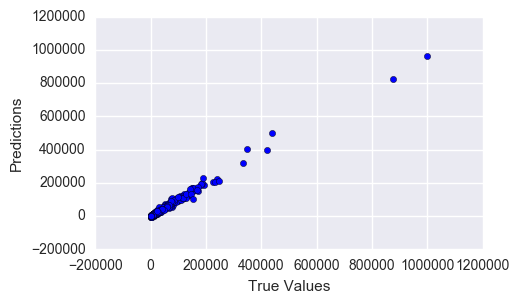

In [40]:
# 6-fold cross validation- Data split into half
dfx = sales_no_NA[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
y = sales_no_NA[["2015 Sales"]]
X_train, X_test, y_train, y_test = train_test_split(dfx, y, test_size=0.5)
lm = linear_model.LinearRegression()

model = lm.fit(X_train,y_train)
predictions=lm.predict(X_test)

# 6-fold cross validation
scores = cross_val_score(lm,dfx,y,cv=6)
print "Score:",model.score(X_test,y_test)

# Cross validated predictions
predictions = cross_val_predict(model, dfx, y, cv=6)
plt.rcParams['figure.figsize'] = 5,3
plt.scatter(y, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
accuracy = metrics.r2_score(y, predictions)
print "Cross-Predicted Accuracy:", accuracy

Score: 0.968431055779
Cross-Predicted Accuracy: 0.989497256193


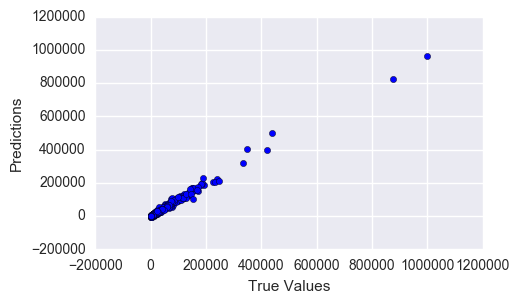

In [41]:
# 6-fold cross validation- Data split 40-60

dfx = sales_no_NA[['2015 Sales Q1','2015 Volume Sold (Liters)','2015 Margin mean','2015 Sales mean']]
y = sales_no_NA[["2015 Sales"]]
X_train, X_test, y_train, y_test = train_test_split(dfx, y, test_size=0.4)
lm = linear_model.LinearRegression()

model = lm.fit(X_train,y_train)
predictions=lm.predict(X_test)

# 6-fold cross validation
scores = cross_val_score(lm,dfx,y,cv=6)
print "Score:",model.score(X_test,y_test)

# Cross validated predictions
predictions = cross_val_predict(model, dfx, y, cv=6)
plt.rcParams['figure.figsize'] = 5,3
plt.scatter(y, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
accuracy = metrics.r2_score(y, predictions)
print "Cross-Predicted Accuracy:", accuracy

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

See above for plots and results

## Present the Results

Present your conclusions and results, including a Tableau Storyboard. If you have more than one interesting model feel free to include.

In [42]:
%%HTML
<div class='tableauPlaceholder' id='viz1479182102062' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;zi&#47;zip-2015sales&#47;countysales&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='zip-2015sales&#47;countysales' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;zi&#47;zip-2015sales&#47;countysales&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1479182102062');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [45]:
%%html
<div class='tableauPlaceholder' id='viz1479182055081' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;zi&#47;zip-2015sales&#47;liquortypevssales&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='zip-2015sales&#47;liquortypevssales' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;zi&#47;zip-2015sales&#47;liquortypevssales&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1479182055081');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

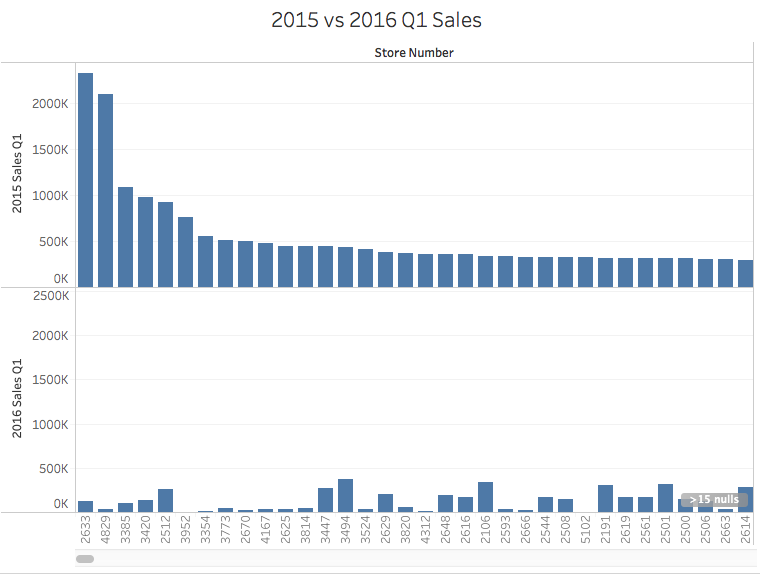

In [44]:
from IPython.display import Image
Image('Q1 2015-2016 comparison.png')

Executive Summary:
1. The dataset contains the spirits purchase information by product and date of purchase from January 1, 2015 to March 31, 2016.
2. The dataset was used to analyze total spirits sales in Iowa of individual products at the store level.
3. In addition, 2015 Q1 sales were used to predict the total sales in 2015 by store number.
4. The top 3 highest sales were generated by Polk, Linn and Scott counties.
5. The most popular liquor sold was Black Velvet Whisky followed by Jack Daniels old #7 Black label and Captain Morgan spiced Rum.
6. The total liquor sales in 2015 was $285 million.
7. The sales in Q1 of 2015 is a good estimator for the total sales in the year. An ordinary least squares linear regression model was evaluated and found to predict the total sales of the year with 98.9% accuracy.
8. 2015 Q1 sales is not a good predictor of 2016 Q1 sales based on individual stores.

#blog link: %%html http://wp.me/p85kqG-y

Score | 20/24
----|----
Identify: Problem Statement and Risks | 0
Acquire: Import with Pandas| 3
Parse: EDA | 3
Mine: Create columns/clean/format/process data| 3
Refine: Determine outliers and distribution, correlation, & statistical analysis| 2
Model: Create linear models; calculate probabilities, evaluate model, perform CV| 3
Present: Create executive summary, present findings, summarize, tailored for your audience| 2
Present: Blog | 2
Bonus: perform Ridge and Lasso regularization and explain what they do | 2